In [1]:
import numpy as np
import cv2
import sklearn
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from scipy.ndimage.measurements import label
import time
import os
import matplotlib.pyplot as plt
from IPython.display import Image
import matplotlib.image as mpimg
%matplotlib inline

Loading the images with defect and generating their masks splitting them into x train and y train respectively.

In [2]:
def load_images_masks(path_to_images, img_type, img_format, resize, ellipse=False):
    IMAGE_CHANNELS = 1
    if not ellipse:
        image_names = [x for x in os.listdir(path_to_images) if x.endswith('.xml')]
    else:
        image_names = [x for x in os.listdir(path_to_images) if x.endswith(img_type)]

    image_num = len(image_names)
    images_all = np.empty([image_num, resize[0], resize[1], IMAGE_CHANNELS])
    labels_all = np.empty([image_num, resize[0], resize[1], IMAGE_CHANNELS])

    if not ellipse:
        image_names = [x.replace('xml', img_type) for x in image_names]

    for image_index in range(image_num):
        image_filename = image_names[image_index]
        # print(image_filename)
        # print(image_filename)
        image = mpimg.imread(os.path.join(path_to_images, image_filename), format=img_format)
        if ellipse:
            mask = get_mask_seg_ellipse(os.path.join(path_to_images, image_filename))
        else:
            mask = get_mask_seg(os.path.join(path_to_images, image_filename))

        if resize:
            image = cv2.resize(image, (resize[0], resize[1]))
            mask = cv2.resize(mask, (resize[0], resize[1]))

        images_all[image_index] = np.reshape(image, (resize[0], resize[1], IMAGE_CHANNELS))
        labels_all[image_index] = np.reshape(mask, (resize[0], resize[1], IMAGE_CHANNELS))

    return images_all, labels_all

In [3]:
def get_mask_seg_ellipse(path_to_img):

    # get the image
    img = mpimg.imread(path_to_img)
    basename = os.path.basename(path_to_img)

    # filename_index, e.g. filename = 1.png
    # filename_index = 1, for extracting coordinates
    filename_index = int(os.path.splitext(basename)[0]) - 1
    # print(filename_index)

    path_to_coordinates = path_to_img.replace(basename, 'labels.txt')
    coordinates = load_coordinates(path_to_coordinates)

    mask = np.zeros_like(img)
    mask = cv2.ellipse(mask, 
                       (int(coordinates[filename_index]['x']), int(coordinates[filename_index]['y'])),
                       (int(coordinates[filename_index]['major_axis']), int(coordinates[filename_index]['minor_axis'])),
                       (coordinates[filename_index]['angle'] / 4.7) * 270,
                       0, 
                       360, 
                       (255, 255, 255), 
                       -1)

    mask[mask > 0] = 1.

    # print(coordinates[filename_index]['angle'])

    return mask

In [4]:
def get_mask_seg(path_to_img, xml=True):

    img = mpimg.imread(path_to_img)

    img_mask = np.zeros_like(img[:, :])

    if xml:
        path_to_xml = path_to_img.replace('bmp', 'xml')
        # print('path_to_xml: {}'.format(path_to_xml))
        coor_obj = get_coordinates(path_to_xml, xml)

        # if there are more than 1 bounding boxes
        if type(coor_obj) is list:
            for i in range(len(coor_obj)):
                xmin = int(coor_obj[i]['bndbox']['xmin'])
                ymin = int(coor_obj[i]['bndbox']['ymin'])
                xmax = int(coor_obj[i]['bndbox']['xmax'])
                ymax = int(coor_obj[i]['bndbox']['ymax'])

                img_mask[ymin:ymax, xmin:xmax] = 1.
        else:
            # there is only one bounding box
            # print('test')
            xmin = int(coor_obj['bndbox']['xmin'])
            ymin = int(coor_obj['bndbox']['ymin'])
            xmax = int(coor_obj['bndbox']['xmax'])
            ymax = int(coor_obj['bndbox']['ymax'])

            img_mask[ymin:ymax, xmin:xmax] = 1.

    return img_mask

In [5]:
def get_coordinates(path_to_label, xml):
    with open(path_to_label, encoding='utf-8') as f:
        if xml:
            label_xml = xmltodict.parse(f.read())

            # print(type(label_xml))
            # print(label_xml)

            coordinates_object = label_xml['annotation']['object']
        else:
            label_txt = f.read()
            coordinates_object = label_txt.strip().split('\n')

    return coordinates_object

In [6]:
def load_coordinates(path_to_coor):
    coord_dict = {}
    coord_dict_all = {}
    with open(path_to_coor) as f:
        coordinates = f.read().split('\n')
        for coord in coordinates:
            # print(len(coord.split('\t')))
            if len(coord.split('\t')) == 6:
                coord_dict = {}
                coord_split = coord.split('\t')
                # print(coord_split)
                # print('\n')
                coord_dict['major_axis'] = round(float(coord_split[1]))
                coord_dict['minor_axis'] = round(float(coord_split[2]))
                coord_dict['angle'] = float(coord_split[3])
                coord_dict['x'] = round(float(coord_split[4]))
                coord_dict['y'] = round(float(coord_split[5]))
                index = int(coord_split[0]) - 1
                coord_dict_all[index] = coord_dict

    return coord_dict_all

Getting the trainning data:

In [7]:
data_dirc1 = "./train/Class1_def"
X1, y1 = load_images_masks(data_dirc1, img_type='png', img_format='gray', resize=(512, 512), ellipse=True)
data_dirc2 = "./train/Class2_def"
X2, y2 = load_images_masks(data_dirc2, img_type='png', img_format='gray', resize=(512, 512), ellipse=True)
data_dirc3 = "./train/Class3_def"
X3, y3 = load_images_masks(data_dirc3, img_type='png', img_format='gray', resize=(512, 512), ellipse=True)
data_dirc4 = "./train/Class4_def"
X4, y4 = load_images_masks(data_dirc4, img_type='png', img_format='gray', resize=(512, 512), ellipse=True)
data_dirc5 = "./train/Class5_def"
X5, y5 = load_images_masks(data_dirc5, img_type='png', img_format='gray', resize=(512, 512), ellipse=True)
data_dirc6 = "./train/Class6_def"
X6, y6 = load_images_masks(data_dirc6, img_type='png', img_format='gray', resize=(512, 512), ellipse=True)

X = np.concatenate([X1, X2, X3, X4, X5, X6], axis = 0)
y = np.concatenate([y1, y2, y3, y4, y5, y6], axis = 0)

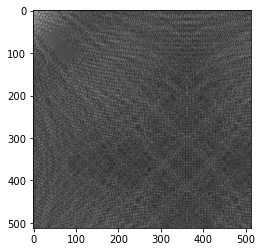

In [12]:
plt.imshow(X[0,:,:,0], cmap='gray')

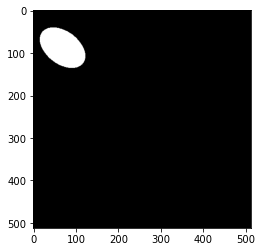

In [11]:
plt.imshow(y[0,:,:,0], cmap='gray')

In [8]:
import sklearn
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [10]:
X_train.shape

(702, 512, 512, 1)

In [13]:
img_rows = 512
img_cols = 512

![](unetcnn.png)

Convolutional neural network (CNN) architecture, based on UNET . Boxes represent cross-sections of square feature maps. Each map's dimensions are indicated on its lower left, and its number of channels are indicated above it. Half-grey boxes represent maps for which half of their channels are copied. The leftmost map is a 256 × 256 grayscale image sampled from the digital elevation map, and the rightmost the CNN's binary ring mask prediction. Arrows represent operations, specified by the legend-notably, blue arrows represent convolutions, while gray ones represent copying (skip connections).

In [14]:
def get_small_unet():
    inputs = Input((img_rows, img_cols, 1))
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(64, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(32, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(16, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(8, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [15]:
model = get_small_unet()

In [16]:
def smooth_dice_coeff(smooth=1.):

    smooth = float(smooth)

    # IOU or dice coeff calculation
    def IOU_calc(y_true, y_pred):
            y_true_f = K.flatten(y_true)
            y_pred_f = K.flatten(y_pred)
            intersection = K.sum(y_true_f * y_pred_f)

            return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def IOU_calc_loss(y_true, y_pred):
        return -IOU_calc(y_true, y_pred)
    return IOU_calc, IOU_calc_loss

IOU_calc, IOU_calc_loss = smooth_dice_coeff(0.00001)

In [17]:
model.compile(optimizer=Adam(lr=1e-4), loss=IOU_calc_loss, metrics=[IOU_calc])

In [18]:
history = model.fit(X_train, y_train, batch_size=10, epochs=100, verbose=1, validation_split = 0.1)

Train on 631 samples, validate on 71 samples
Epoch 1/100
631/631 [==============================] - 24s 38ms/sample - loss: -0.0630 - IOU_calc: 0.0630 - val_loss: -0.0567 - val_IOU_calc: 0.0614
Epoch 2/100
631/631 [==============================] - 15s 24ms/sample - loss: -0.0840 - IOU_calc: 0.0835 - val_loss: -0.0810 - val_IOU_calc: 0.0826
Epoch 3/100
631/631 [==============================] - 16s 25ms/sample - loss: -0.3343 - IOU_calc: 0.3296 - val_loss: -0.3021 - val_IOU_calc: 0.2682
Epoch 4/100
631/631 [==============================] - 16s 25ms/sample - loss: -0.4734 - IOU_calc: 0.4667 - val_loss: -0.3182 - val_IOU_calc: 0.2824
Epoch 5/100
631/631 [==============================] - 16s 25ms/sample - loss: -0.4919 - IOU_calc: 0.4850 - val_loss: -0.3279 - val_IOU_calc: 0.2910
Epoch 6/100
631/631 [==============================] - 16s 25ms/sample - loss: -0.4986 - IOU_calc: 0.5031 - val_loss: -0.3302 - val_IOU_calc: 0.2930
Epoch 7/100
631/631 [==============================] - 15s 25

631/631 [==============================] - 16s 25ms/sample - loss: -0.5597 - IOU_calc: 0.5518 - val_loss: -0.4398 - val_IOU_calc: 0.3903
Epoch 56/100
631/631 [==============================] - 16s 25ms/sample - loss: -0.5847 - IOU_calc: 0.5902 - val_loss: -0.4423 - val_IOU_calc: 0.3925
Epoch 57/100
631/631 [==============================] - 16s 25ms/sample - loss: -0.5817 - IOU_calc: 0.5736 - val_loss: -0.4361 - val_IOU_calc: 0.3871
Epoch 58/100
631/631 [==============================] - 16s 25ms/sample - loss: -0.5398 - IOU_calc: 0.5455 - val_loss: -0.4367 - val_IOU_calc: 0.3876
Epoch 59/100
631/631 [==============================] - 16s 25ms/sample - loss: -0.5638 - IOU_calc: 0.5559 - val_loss: -0.4430 - val_IOU_calc: 0.3932
Epoch 60/100
631/631 [==============================] - 16s 25ms/sample - loss: -0.5651 - IOU_calc: 0.5571 - val_loss: -0.4343 - val_IOU_calc: 0.3854
Epoch 61/100
631/631 [==============================] - 16s 25ms/sample - loss: -0.5617 - IOU_calc: 0.5538 - val_

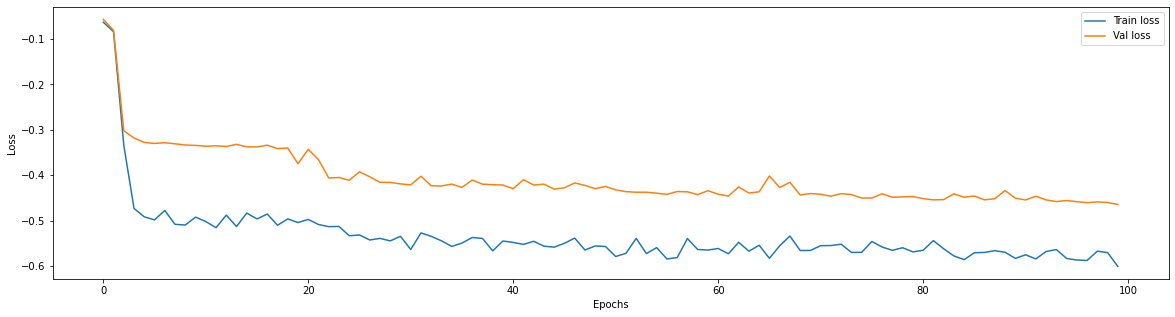

In [19]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Train loss')
plt.plot(model.history.history['val_loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

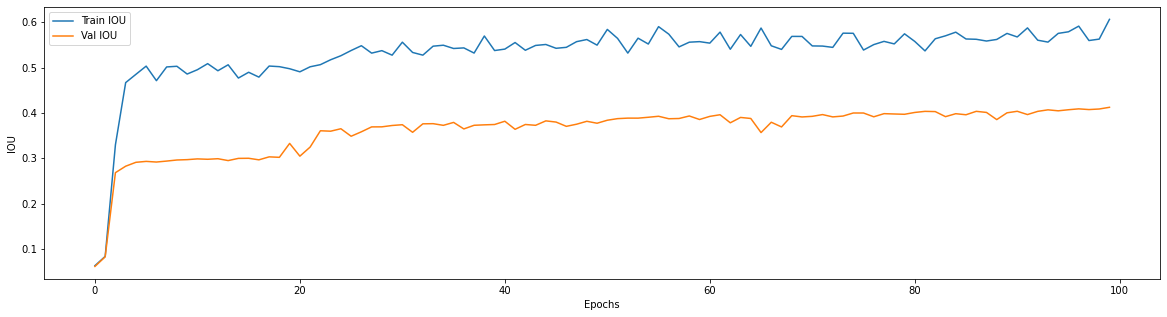

In [20]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['IOU_calc'], label='Train IOU')
plt.plot(model.history.history['val_IOU_calc'], label='Val IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()

In [21]:
def load_test_images(folder, img_type, img_format, resize, ellipse=False):
    IMAGE_CHANNELS = 1
    IMAGE_HEIGHT = resize[0]
    IMAGE_WIDTH = resize[1]
    
    image_names = [x for x in os.listdir(folder) if x.endswith(img_type)]
    image_num = len(image_names)
    images_all = np.empty([image_num, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])

    for image_index in range(image_num):
        image_filename = image_names[image_index]
        # print(image_filename)
        image = mpimg.imread(os.path.join(folder, image_filename), format=img_format)
        if resize:
            image = cv2.resize(image, (resize[0], resize[1]))

        images_all[image_index] = np.reshape(image, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    
    return images_all, image_num


In [24]:
test_dir = "./test"
X_t, num = load_test_images(test_dir, img_type='png', img_format='gray', resize=(512, 512))

In [22]:
pred = model.predict(X_test)

In [23]:
pred.shape

(78, 512, 512, 1)

In [25]:
def predict_evaluation(pred, image, label):
    '''
    '''
    # transform gray image to rgb
    img = np.array(image, np.uint8)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # scale pred and mask's pixel range to 0~255
    im_label = np.array(255*label, dtype=np.uint8)
    im_pred = np.array(255*pred, dtype=np.uint8)

    # transform both of them to rgb
    rgb_label = cv2.cvtColor(im_label, cv2.COLOR_GRAY2RGB)
    rgb_pred = cv2.cvtColor(im_pred, cv2.COLOR_GRAY2RGB)

    rgb_label[:, :, 1:3] = 0*rgb_label[:, :, 1:2]
    rgb_pred[:, :, 0] = 0*rgb_pred[:, :, 0]
    rgb_pred[:, :, 2] = 0*rgb_pred[:, :, 2]    

    img_pred = cv2.addWeighted(rgb_img, 1, rgb_pred, 0.3, 0)
    img_label = cv2.addWeighted(rgb_img, 1, rgb_label, 0.3, 0)

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb_img)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(img_pred)
    plt.title('Prediction')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(img_label)
    plt.title('Ground truth')
    plt.axis('off')

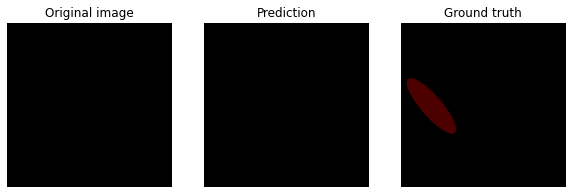

In [27]:
predict_evaluation(pred[0,:,:,0], X_test[0,:,:,0], y_test[0,:,:,0])

In [28]:
predict = model.predict(X_t)

In [29]:
def pred_evaluation(pred, image, image_num):
    img = np.array(image, np.uint8)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    im_pred = np.array(255*pred, dtype=np.uint8)

    rgb_pred = cv2.cvtColor(im_pred, cv2.COLOR_GRAY2RGB)

    rgb_pred[:, :, 0] = 0*rgb_pred[:, :, 0]
    rgb_pred[:, :, 2] = 0*rgb_pred[:, :, 2]

    img_pred = cv2.addWeighted(rgb_img, 1, rgb_pred, 0.3, 0)
    image_num = str(image_num)
    path = "./test_output"
    cv2.imwrite(os.path.join(path, image_num, '.png'), img_pred)

In [31]:
for x in range(num):
    pred_evaluation(predict[x,:,:,0], X_t[x,:,:,0], x)

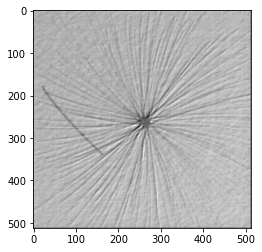

In [32]:
plt.imshow(X_test[0,:,:,0], cmap='gray')

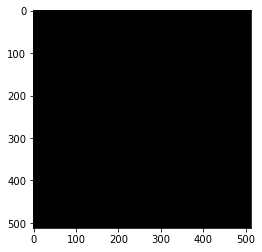

In [33]:
image = np.array(X_test[0,:,:,0])
img = np.array(image, np.uint8)
rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)


predict = np.array(pred[0,:,:,0])
im_pred = np.array(255*predict, dtype=np.uint8)
rgb_pred = cv2.cvtColor(im_pred, cv2.COLOR_GRAY2RGB)
rgb_pred[:, :, 0] = 0*rgb_pred[:, :, 0]
rgb_pred[:, :, 2] = 0*rgb_pred[:, :, 2]
img_pred = cv2.addWeighted(rgb_img, 1, rgb_pred, 0.3, 0)
plt.imshow(img_pred)